In [1]:
import shutil
import os
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchaudio
import soundfile as sf
from torchaudio.datasets import SPEECHCOMMANDS
import matplotlib.pyplot as plt
import torch.nn.functional as F
import librosa
import cv2
import numpy as np
from IPython.display import Audio
from PIL import Image
import soundfile as sf
import torch.nn
import torchaudio.functional as F
import math

In [2]:
! git clone https://github.com/IFMW01/R255_ifm24_ProtoPNet_4_Audio.git

Cloning into 'R255_ifm24_ProtoPNet_4_Audio'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 281 (delta 133), reused 164 (delta 118), pack-reused 33
Receiving objects: 100% (281/281), 183.72 MiB | 18.67 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
labels =['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [5]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

train_set = SubsetSC("training",)
test_set = SubsetSC("testing")

100%|██████████| 2.26G/2.26G [00:29<00:00, 83.0MB/s]


In [6]:
test_item_path = "./SpeechCommands/speech_commands_v0.02/"
houses = ["right/bb05582b_nohash_3.wav", "right/f2e59fea_nohash_0.wav", "bed/beb458a4_nohash_0.wav", "learn/bfd26d6b_nohash_4.wav"]


In [7]:
class SpecToWav(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=1024,
        n_mel=32,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.inversespec = torchaudio.transforms.GriffinLim(n_fft)

    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        inversespec = librosa.db_to_power(spec)
        waveform = self.inversespec(inversespec)

        return waveform

In [8]:
class WavToSpec(torch.nn.Module):
    def __init__(
        self,
        n_fft=1024,
    ):
        super().__init__()

        self.spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, power=4)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        spec = self.spec(waveform)
        spec = torch.from_numpy(librosa.power_to_db(spec))

        return spec

In [9]:
class MelToWav(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=1024,
        n_mel=32,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.inverseMel = torchaudio.transforms.InverseMelScale(n_stft = n_fft // 2 + 1 , n_mels = 32, sample_rate = 16000)

        self.inversespec = torchaudio.transforms.GriffinLim(n_fft)

    def forward(self, mel: torch.Tensor) -> torch.Tensor:
        mel = librosa.db_to_power(mel)
        invertedMel = self.inverseMel(mel)
        waveform = self.inversespec(invertedMel)

        return waveform

In [10]:
class WavToMel(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=1024,
        n_mel=32,
        stretch_factor=0.8,
    ):
        super().__init__()

        self.spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, power=2)

        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        spec = self.spec(waveform)
        # spec = torch.from_numpy(librosa.power_to_db(spec))
        mel = self.mel_scale(spec)
        mel = torch.from_numpy(librosa.power_to_db(mel))

        return mel

In [ ]:
for idx , i in enumerate(houses):
    path = test_item_path+i
    audio, sample_rate = sf.read(path)
    features = WavToSpec()(torch.Tensor(audio))
    features = features[:,:,None]
    features = torch.einsum("hwc->whc",features)
    np.save(f"{idx}.npy", features.detach().numpy())

# Showing testing examples for spectrograms

right

In [ ]:
npy_spec_test = np.load("1.npy")
npy_spec_test = torch.from_numpy(npy_spec_test)
npy_spec_test = torch.einsum('hwc->whc',npy_spec_test)
npy_spec_test = torch.einsum('whc->cwh',npy_spec_test)
waveform_test = SpecToWav()(npy_spec_test)
Audio(waveform_test.numpy(), rate=16000)

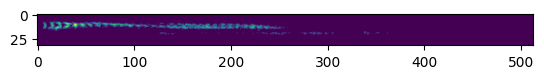

In [ ]:
plt.imshow(np.load("1.npy"))

bed

In [ ]:
npy_spec_test = np.load("2.npy")
npy_spec_test = torch.from_numpy(npy_spec_test)
npy_spec_test = torch.einsum('hwc->whc',npy_spec_test)
npy_spec_test = torch.einsum('whc->cwh',npy_spec_test)
waveform_test = SpecToWav()(npy_spec_test)
Audio(waveform_test.numpy(), rate=16000)

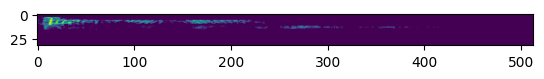

In [ ]:
plt.imshow(np.load("2.npy"))

learn

In [ ]:
npy_spec_test = np.load("3.npy")
npy_spec_test = torch.from_numpy(npy_spec_test)
npy_spec_test = torch.einsum('hwc->whc',npy_spec_test)
npy_spec_test = torch.einsum('whc->cwh',npy_spec_test)
waveform_test = SpecToWav()(npy_spec_test)
Audio(waveform_test.numpy(), rate=16000)

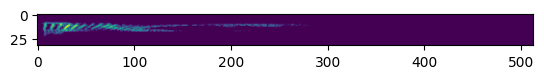

In [ ]:
plt.imshow(np.load("3.npy"))

# Test evaluation of spectogram prototypes

In [ ]:
model_path = '40push0.6939.pth'
test_dir_spec = '/content/Test_Spec'
model_dir = '/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/model'
spec = '0.npy'



In [ ]:
! python /content/R255_ifm24_ProtoPNet_4_Audio/local_analysis.py -model '40push0.6939.pth' -imgdir  '/content/Test_Spec' -img '0.npy' -imgclass 22 -modeldir '/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/model'

load model from /content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/model/40push0.6939.pth
model base architecture: drive
experiment run: MyDrive/ProtoPNet/Spec/epoch_40_spec/model
Prototypes are chosen from 35 number of classes.
Their class identities are: [ 0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7
  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15
 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23
 24 24 24 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31
 32 32 32 33 33 33 34 34 34]
All prototypes connect most strongly to their respective classes.
0 (18, 22)
Predicted: 18
Actual: 22
Most activated 3 prototypes of this image:
top 1 activated prototype for this image:
prototype index: 59
prototype class identity: 19
activation value (similarity score): 3.835827112197876
last layer connection with predicted class: -0.5481534004211426
most highly activated patch of the chosen image by this prototype:

Test Example

In [ ]:
npy_spec_test = np.load("Test_Spec/0.npy")
npy_spec_test = torch.from_numpy(npy_spec_test)
npy_spec_test = torch.einsum('hwc->whc',npy_spec_test)
npy_spec_test = torch.einsum('whc->cwh',npy_spec_test)
waveform_test = SpecToWav()(npy_spec_test)
Audio(waveform_test.numpy(), rate=16000)

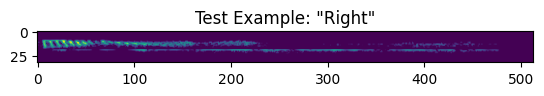

In [ ]:
test_0 = np.load("Test_Spec/0.npy")
plt.title('Test Example: "Right"')
plt.imshow(test_0)
plt.savefig('0.pdf')

Matched Prototype

In [ ]:
npy_spec_test = np.load("/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/epoch-40/prototype-img-original59.npy")
npy_spec_test = torch.from_numpy(npy_spec_test)
npy_spec_test = torch.einsum('hwc->whc',npy_spec_test)
npy_spec_test = torch.einsum('whc->chw',npy_spec_test)
waveform_test = SpecToWav()(npy_spec_test)
Audio(waveform_test.numpy(), rate=16000)

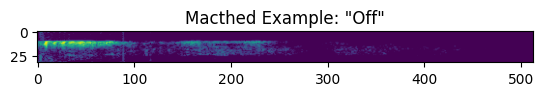

In [ ]:
npy_spec_test = torch.einsum('chw->whc',npy_spec_test)
plt.title('Macthed Example: "Off"')
plt.imshow(npy_spec_test)
plt.savefig('59.pdf')

(513, 32, 1)


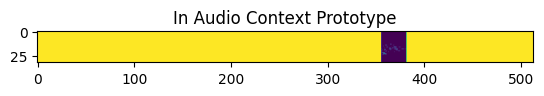

In [ ]:
npy_protofull_spec = np.load("/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/epoch-40/prototype-img59_FULL.npy")
print(npy_protofull_spec.shape)
npy_protofull_spec = torch.from_numpy(npy_protofull_spec)
plt.imshow(npy_protofull_spec)
npy_protofull_spec_mod = torch.where(npy_protofull_spec==0, -150, npy_protofull_spec)
npy_protofull_spec = torch.einsum('hwc->whc',npy_protofull_spec)
npy_protofull_spec_mod = torch.einsum('hwc->whc',npy_protofull_spec_mod)
plt.title('In Audio Context Prototype')
plt.imshow(npy_protofull_spec)
plt.savefig('59_proto_full.pdf')
npy_protofull_spec_mod = torch.einsum('whc->chw',npy_protofull_spec_mod)
# # Perform the transform
waveform_90 = SpecToWav()(npy_protofull_spec_mod)
Audio(waveform_90.numpy(), rate=16000)

In [ ]:
! python /content/R255_ifm24_ProtoPNet_4_Audio/local_analysis.py -model '40push0.6939.pth' -imgdir  '/content/Test_Spec' -img '1.npy' -imgclass 22 -modeldir '/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/model'

load model from /content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/model/40push0.6939.pth
model base architecture: drive
experiment run: MyDrive/ProtoPNet/Spec/epoch_40_spec/model
Prototypes are chosen from 35 number of classes.
Their class identities are: [ 0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7
  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15
 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23
 24 24 24 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31
 32 32 32 33 33 33 34 34 34]
All prototypes connect most strongly to their respective classes.
0 (17, 22)
Predicted: 17
Actual: 22
Most activated 3 prototypes of this image:
top 1 activated prototype for this image:
prototype index: 59
prototype class identity: 19
activation value (similarity score): 3.451770544052124
last layer connection with predicted class: -0.43314844369888306
most highly activated patch of the chosen image by this prototype

In [ ]:
npy_spec_test = np.load("Test_Spec/1.npy")
npy_spec_test = torch.from_numpy(npy_spec_test)
npy_spec_test = torch.einsum('hwc->whc',npy_spec_test)
npy_spec_test = torch.einsum('whc->cwh',npy_spec_test)
waveform_test = SpecToWav()(npy_spec_test)
Audio(waveform_test.numpy(), rate=16000)


In [ ]:
npy_spec_test = np.load("/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/epoch-40/prototype-img-original59.npy")
npy_spec_test = torch.from_numpy(npy_spec_test)
npy_spec_test = torch.einsum('hwc->whc',npy_spec_test)
npy_spec_test = torch.einsum('whc->chw',npy_spec_test)
waveform_test = SpecToWav()(npy_spec_test)
Audio(waveform_test.numpy(), rate=16000)

(513, 32, 1)


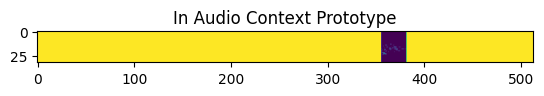

In [ ]:
npy_spec_test = torch.einsum('chw->whc',npy_spec_test)
plt.title('Macthed Example: "Off"')
plt.imshow(npy_spec_test)
plt.savefig('59.pdf')


(513, 32, 1)


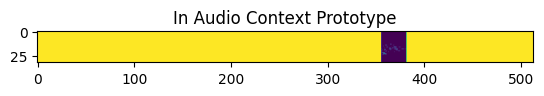

In [ ]:
npy_protofull_spec = np.load("/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/epoch-40/prototype-img59_FULL.npy")
print(npy_protofull_spec.shape)
npy_protofull_spec = torch.from_numpy(npy_protofull_spec)
plt.imshow(npy_protofull_spec)
npy_protofull_spec_mod = torch.where(npy_protofull_spec==0, -150, npy_protofull_spec)
npy_protofull_spec = torch.einsum('hwc->whc',npy_protofull_spec)
npy_protofull_spec_mod = torch.einsum('hwc->whc',npy_protofull_spec_mod)
plt.title('In Audio Context Prototype')
plt.imshow(npy_protofull_spec)
plt.savefig('59_proto_full.pdf')
npy_protofull_spec_mod = torch.einsum('whc->chw',npy_protofull_spec_mod)
# # Perform the transform
waveform_90 = SpecToWav()(npy_protofull_spec_mod)
Audio(waveform_90.numpy(), rate=16000)

In [ ]:
! python /content/R255_ifm24_ProtoPNet_4_Audio/local_analysis.py -model '40push0.6939.pth' -imgdir  '/content/Test_Spec' -img '2.npy' -imgclass 1 -modeldir '/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/model'

load model from /content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/model/40push0.6939.pth
model base architecture: drive
experiment run: MyDrive/ProtoPNet/Spec/epoch_40_spec/model
Prototypes are chosen from 35 number of classes.
Their class identities are: [ 0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7
  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15
 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23
 24 24 24 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31
 32 32 32 33 33 33 34 34 34]
All prototypes connect most strongly to their respective classes.
0 (10, 1)
Predicted: 10
Actual: 1
Most activated 3 prototypes of this image:
top 1 activated prototype for this image:
prototype index: 59
prototype class identity: 19
activation value (similarity score): 3.5208473205566406
last layer connection with predicted class: -0.4256158769130707
most highly activated patch of the chosen image by this prototype:


In [ ]:
! python /content/R255_ifm24_ProtoPNet_4_Audio/local_analysis.py -model '40push0.6939.pth' -imgdir  '/content/Test_Spec' -img '3.npy' -imgclass 14 -modeldir '/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/model'

load model from /content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/model/40push0.6939.pth
model base architecture: drive
experiment run: MyDrive/ProtoPNet/Spec/epoch_40_spec/model
Prototypes are chosen from 35 number of classes.
Their class identities are: [ 0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7
  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15
 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23
 24 24 24 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31
 32 32 32 33 33 33 34 34 34]
All prototypes connect most strongly to their respective classes.
0 (17, 14)
Predicted: 17
Actual: 14
Most activated 3 prototypes of this image:
top 1 activated prototype for this image:
prototype index: 59
prototype class identity: 19
activation value (similarity score): 3.710707426071167
last layer connection with predicted class: -0.43314844369888306
most highly activated patch of the chosen image by this prototype

# Mel Spectrogram Example

In [12]:
for idx , i in enumerate(houses):
    path = test_item_path+i
    audio, sample_rate = sf.read(path)
    features = WavToMel()(torch.Tensor(audio))
    features = features[:,:,None]
    features = torch.einsum("hwc->whc",features)
    np.save(f"{idx}.npy", features.detach().numpy())

In [13]:
! python /content/R255_ifm24_ProtoPNet_4_Audio/local_analysis.py -model '40push0.8585.pth' -imgdir  '/content/Test_Mel' -img '0.npy' -imgclass 22 -modeldir '/content/drive/MyDrive/ProtoPNet/Mel/model'

load model from /content/drive/MyDrive/ProtoPNet/Mel/model/40push0.8585.pth
model base architecture: drive
experiment run: MyDrive/ProtoPNet/Mel/model
Prototypes are chosen from 35 number of classes.
Their class identities are: [ 0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7
  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15
 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23
 24 24 24 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31
 32 32 32 33 33 33 34 34 34]
All prototypes connect most strongly to their respective classes.
0 (3, 22)
Predicted: 3
Actual: 22
Most activated 3 prototypes of this image:
top 1 activated prototype for this image:
prototype index: 41
prototype class identity: 13
activation value (similarity score): 2.5508222579956055
last layer connection with predicted class: -0.15388287603855133
most highly activated patch of the chosen image by this prototype:
most highly activated patch b

(32, 32, 1)


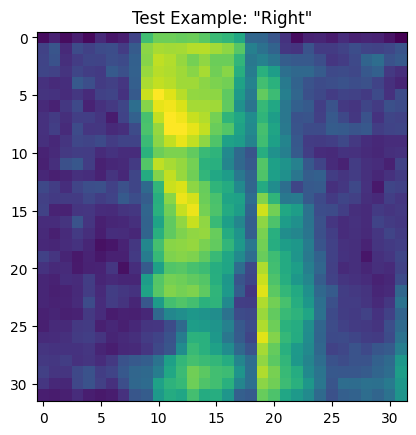

In [14]:
npy_orginal_mel = np.load('/content/Test_Mel/0.npy')
print(npy_orginal_mel.shape)
npy_orginal_mel = torch.from_numpy(npy_orginal_mel)
npy_protofull_mel_mod = npy_orginal_mel
npy_orginal_mel = torch.einsum('hwc->whc',npy_orginal_mel)
npy_protofull_mel_mod = torch.einsum('hwc->whc',npy_protofull_mel_mod)
plt.title('Test Example: "Right"')
plt.imshow(npy_protofull_mel_mod)
plt.savefig('1.pdf')
npy_protofull_mel_mod = torch.einsum('whc->chw',npy_protofull_mel_mod)
npy_protofull_mel_mod = npy_protofull_mel_mod.tolist()
npy_protofull_mel_mod = torch.Tensor(npy_protofull_mel_mod)
# # Perform the transform
waveform_spec = MelToWav()(npy_protofull_mel_mod)
Audio(waveform_spec.numpy(), rate=16000)

(32, 32, 1)


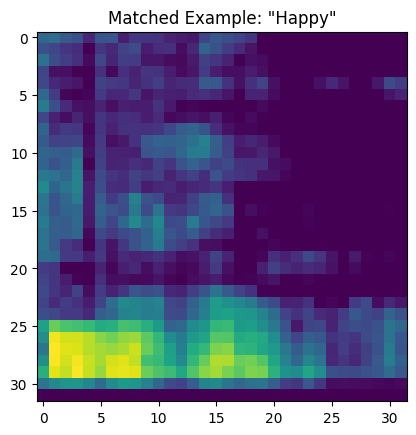

In [16]:
npy_orginal_mel = np.load('/content/drive/MyDrive/ProtoPNet/Mel/epoch-40/prototype-img-original40.npy')
print(npy_orginal_mel.shape)
npy_orginal_mel = torch.from_numpy(npy_orginal_mel)
npy_protofull_mel_mod = npy_orginal_mel
npy_orginal_mel = torch.einsum('hwc->whc',npy_orginal_mel)
npy_protofull_mel_mod = torch.einsum('hwc->whc',npy_protofull_mel_mod)
plt.title('Matched Example: "Happy"')
plt.imshow(npy_protofull_mel_mod)
plt.savefig('40_og.pdf')
npy_protofull_mel_mod = torch.einsum('whc->chw',npy_protofull_mel_mod)
npy_protofull_mel_mod = npy_protofull_mel_mod.tolist()
npy_protofull_mel_mod = torch.Tensor(npy_protofull_mel_mod)
# # Perform the transform
waveform_spec = MelToWav()(npy_protofull_mel_mod)
Audio(waveform_spec.numpy(), rate=16000)

(32, 32, 1)


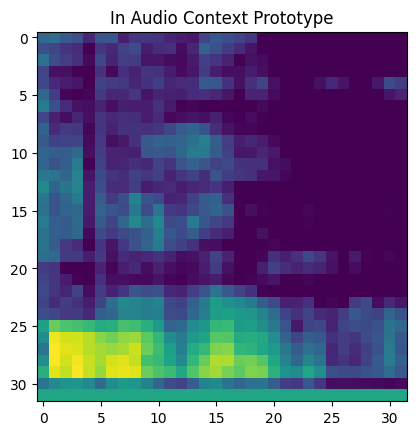

In [18]:
npy_orginal_mel = np.load('/content/drive/MyDrive/ProtoPNet/Mel/epoch-40/prototype-img40_FULL.npy')
print(npy_orginal_mel.shape)
npy_orginal_mel = torch.from_numpy(npy_orginal_mel)
npy_protofull_mel_mod = npy_orginal_mel
npy_orginal_mel = torch.einsum('hwc->whc',npy_orginal_mel)
npy_protofull_mel_mod = torch.einsum('hwc->whc',npy_protofull_mel_mod)
plt.title('In Audio Context Prototype')
plt.imshow(npy_protofull_mel_mod)
plt.savefig('40_FULL.pdf')
npy_protofull_mel_mod = torch.einsum('whc->chw',npy_protofull_mel_mod)
npy_protofull_mel_mod = npy_protofull_mel_mod.tolist()
npy_protofull_mel_mod = torch.Tensor(npy_protofull_mel_mod)
# # Perform the transform
waveform_spec = MelToWav()(npy_protofull_mel_mod)
Audio(waveform_spec.numpy(), rate=16000)